In [67]:
import geopandas as gpd
import pandas as pd

## Merging Geographic Dataframes with Dataframes without Geographic Data

You might need to reference information found in a dataset that **doesn't** contain geopgraphic data. One such example is the tax records found in the COV Opendata Portal.

For this example, I am going to merge [the most recent tax report](https://opendata.vancouver.ca/explore/dataset/property-tax-report/export/) with [the property parcel polygon dataset](https://opendata.vancouver.ca/explore/dataset/property-parcel-polygons/export/?disjunctive.streetname&geofilter.polygon=(49.2566019569463,-123.2344665558776),(49.28695509355089,-123.2344665558776),(49.28695509355089,-123.17695999459829),(49.2566019569463,-123.17695999459829),(49.2566019569463,-123.2344665558776)&location=13,49.27027,-123.20292) cropped to the West End.

*Note: You will have to download the tax data from the COV opendata website and add it to your data folder.*

*Note: The property parcel link will lead to the proper cropping if you want to follow this notebook exactly.*

---

### Step 1. Import the non-geographic dataset with Pandas

We need to use pandas to import this sort of data properly. Pandas is installed as a dependency of geopandas. Just type `import pandas as pd` as I've done above. You will also need to install `pyarrow` to read the parquet file.

In [68]:
# read in the file and preview data
tax_records = pd.read_parquet("data/tax.parquet")

tax_records.head(4)

,pid,legal_type,folio,land_coordinate,zoning_district,zoning_classification,lot,plan,block,district_lot,...,current_land_value,current_improvement_value,tax_assessment_year,previous_land_value,previous_improvement_value,year_built,big_improvement_year,tax_levy,neighbourhood_code,report_year
0,013-885-910,LAND,289602150000,28960215,RS-1,One-Family Dwelling,38,VAP2343,2,THSL,...,1192000.0,36400.0,2021,1068000.0,35700.0,1929,1955,5779.00,020,2021
1,026-377-667,STRATA,162604050369,16260405,CD-1 (324),Comprehensive Development,369,BCS1437,None,FC,...,340000.0,152000.0,2021,347000.0,150000.0,2005,2005,1437.87,030,2021
2,004-465-342,LAND,084643060000,08464306,RM-4,Multiple Dwelling,1,VAP590,283,526,...,1783000.0,1669000.0,2021,1935000.0,1627000.0,1910,1910,10699.40,002,2021
3,028-717-511,STRATA,210719020112,21071902,C-2,Commercial,112,EPS458,None,391,...,539000.0,210000.0,2021,514000.0,206000.0,2011,2011,2188.96,016,2021


For this example, we will look at `year_built`. 

We will use the column `folio` to cross reference against the property parcels data set. We know this because we can look at the *schema* for both datasets on the COV Opendata portal.

From the tax records schema:

<img src="img\tax.png" width="600"> 

<br>

From the property parcels schema:

<img src="img\parcels.png" width="600"> 

<br>

We can see that we need to convert the `folio` column to the first 8 digits to match against the property parcel polygons.


*Note: Pandas works the same as GeoPandas! You just can't perform geometric operations*

In [69]:
# grab only the columns we need and preview
tax_records = tax_records[["folio", "year_built"]]

tax_records.head(4)

,folio,year_built
0,289602150000,1929
1,162604050369,2005
2,084643060000,1910
3,210719020112,2011


Let's look at what type of object the folio column is composed of.

In [70]:
type(tax_records.loc[0, "folio"])

str

It's a string, so we can grab the first 8 digits using slice notation. Note, that [referencing this post](https://stackoverflow.com/questions/51607400/how-to-extract-first-8-characters-from-a-string-in-pandas) we still need to use the `.str` attribute.

In [71]:
tax_records["tax_num"] = tax_records["folio"].str[:8]

tax_records = tax_records[["tax_num", "year_built"]]

# drop nulls just in case
tax_records = tax_records.dropna()

tax_records.head(4)

,tax_num,year_built
0,28960215,1929
1,16260405,2005
2,08464306,1910
3,21071902,2011


### Step 2. Import the geo-data
Now we can import the geographic data just like we did in class.

In [72]:
# read in the file
parcels = gpd.read_file("data/parcels.geojson")

# set the proper CRS
parcels = parcels.set_crs(epsg=26910, allow_override=True)

# drop null values
parcels = parcels.dropna()

# preview
parcels.head(4)

,civic_number,streetname,tax_coord,site_id,geo_point_2d,geometry
0,3145,WATERLOO ST,04568845,015021262,"{ ""lon"": 486866.26081794023, ""lat"": 5456202.55...","POLYGON ((486849.071 5456197.988, 486883.197 5..."
1,3296,W 15TH AV,68805004,013986864,"{ ""lon"": 487059.62023580464, ""lat"": 5456213.57...","POLYGON ((487064.145 5456194.902, 487064.145 5..."
2,3278,W 15TH AV,68805012,013986872,"{ ""lon"": 487069.66952102009, ""lat"": 5456213.31...","POLYGON ((487074.195 5456194.643, 487074.195 5..."
3,3274,W 15TH AV,68805020,013986881,"{ ""lon"": 487079.71844424674, ""lat"": 5456213.05...","POLYGON ((487084.244 5456194.383, 487084.244 5..."


Let's reduce this to only the `tax_coord` column and the `geometry_column`. 

For this process, we also need the 2 columns to have the same name. In this case, we can set both to be `tax_num`. We will use the method `.rename()`. See [this link](https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/) and the example below for the specific syntax.

In [73]:
# grab only the needed data
parcels = parcels[["tax_coord", "geometry"]]

# renaming the tax_coord column to tax_num
parcels.rename(columns={'tax_coord': 'tax_num'}, inplace=True)

parcels.head(6)

,tax_num,geometry
0,04568845,"POLYGON ((486849.071 5456197.988, 486883.197 5..."
1,68805004,"POLYGON ((487064.145 5456194.902, 487064.145 5..."
2,68805012,"POLYGON ((487074.195 5456194.643, 487074.195 5..."
3,68805020,"POLYGON ((487084.244 5456194.383, 487084.244 5..."
4,68804538,"POLYGON ((486983.8 5456197.111, 486984.751 545..."
5,68804574,"POLYGON ((487003.914 5456196.572, 487013.949 5..."


<Axes: >

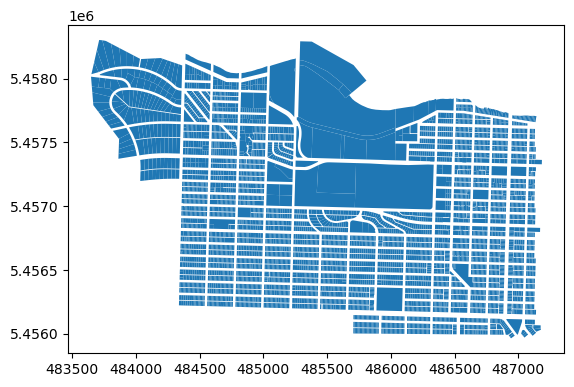

In [74]:
# plot the data
parcels.plot()

### Step 2. Merging the Data

You can refer to the [geopandas documentation](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html) for more info, but in a nutshell, we can simply use the `.merge` method to join this geodataframe with the tax records dataframe.

The documentation tells us to call the `.merge` method from the spatial dataset - in this case, the property parcels. We use the parameter `on` to specify the column to merge on.

In [75]:
# merge the data
parcels = parcels.merge(tax_records, on="tax_num")

# preview
parcels.head(6)

,tax_num,geometry,year_built
0,04568845,"POLYGON ((486849.071 5456197.988, 486883.197 5...",1950
1,04568845,"POLYGON ((486849.071 5456197.988, 486883.197 5...",1950
2,04568845,"POLYGON ((486849.071 5456197.988, 486883.197 5...",1950
3,04568845,"POLYGON ((486849.071 5456197.988, 486883.197 5...",1950
4,04568845,"POLYGON ((486849.071 5456197.988, 486883.197 5...",1950
5,68805004,"POLYGON ((487064.145 5456194.902, 487064.145 5...",1947


That's it! We can now plot to visualize the age of lots in this part of the city.

<Axes: >

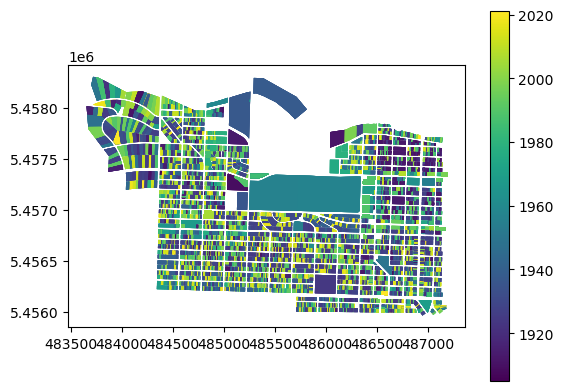

In [76]:
# the year built column was full of strings - so it plotted with individual labels
# I converted to an int column so we can get the gradient bar graph
parcels["year_built"] = parcels["year_built"].astype(int)

parcels.plot("year_built", legend=True)